# From snippets to model

## General imports

In [63]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import pickle

import librosa
import librosa.display
from librosa.effects import time_stretch, pitch_shift
import audiomentations as AA
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve

import xgboost as xgb

## Setting up folder path

In [64]:
folder = '/Users/rblc/code/iamrblc/laica/audio/mariana_data/snippet_samples'

## Creating the base snippet dataframe

In [65]:
def snippet_df_maker(folder = folder):
    # Create empty lists to store the data
    file_names = []
    srs = []
    audios = []
    labels = []
    
    file_list = sorted(os.listdir(folder))
    
    for file in file_list:
        '''MAC creates a .DS_Store file in every folder, which causes an error
        this if statement skips the .DS_Store file'''
        if file.endswith('.wav'):                
            # load the audio file with librosa
            audio, sr = librosa.load(os.path.join(folder, file))
            
            # normalize the audio with librosa normalizer
            audio = librosa.util.normalize(audio)
            
            # split the filename into the label and ID columns
            label = file.split('_')[0]
            
            # append the extracted features to the lists
            file_names.append(file)
            srs.append(sr)
            audios.append(audio)
            labels.append(label)

            # convert the lists to a pandas dataframe
            df = pd.DataFrame(
                {'file_name':file_names,
                'sample_rate': srs,
                'audio': audios,
                'label': labels,})
            
            # add length column
            df['length'] = (df['audio'].apply(lambda x: len(x))/df['sample_rate'])
            
            # include only rows where length between 0.2 and 4 seconds
            df = df[df['length'] > 0.2]
            df = df[df['length'] < 4]
         
    return df

In [66]:
snippet_df = snippet_df_maker()

### Brief check

### Reduce df to the most important features

In [67]:
# Create df with only file_name, and label columns
snippet_df = snippet_df[['file_name', 'length', 'audio', 'label']]

### Quick check 

In [68]:
snippet_df.head()

,file_name,length,audio,label
0,bark_00001.wav,0.695964,"[0.023036616, 0.023904754, 0.02477289, 0.02347...",bark
1,bark_00005.wav,1.088027,"[0.0009460449, 0.001159668, 0.00091552734, 0.0...",bark
2,bark_00009.wav,0.991973,"[0.0, 0.0, -6.195211e-05, 0.0, 9.292817e-05, 0...",bark
3,bark_00012.wav,0.728027,"[-0.004835945, -0.006917238, -0.006090842, -0....",bark
4,bark_00019.wav,0.444989,"[-0.029972471, -0.047773186, -0.04336713, -0.0...",bark


In [69]:
# CHANGE THIS TO 4 SECONDS IN LIVE VERSION
# Create new df of audios between 0.2 and 4 seconds
snippet_df = snippet_df[(snippet_df['length'] >= 0.2) & (snippet_df['length'] <= 4)]


In [70]:
snippet_df.length.describe()

count    3587.000000
mean        1.282093
std         0.844429
min         0.206984
25%         0.608027
50%         1.000000
75%         1.751020
max         3.997007
Name: length, dtype: float64

(array([ 23.,  39.,  53.,  69.,  57., 205.,  75.,  68.,  59.,  75., 208.,
         81.,  78.,  86.,  47., 174.,  69.,  51.,  70.,  58., 154.,  49.,
         47.,  38.,  28.,  46., 121.,  43.,  35.,  27.,  36., 113.,  34.,
         45.,  37.,  32.,  84.,  19.,  22.,  23.,  13.,  23.,  78.,  17.,
         18.,  17.,  12.,  62.,  13.,  18.,  18.,  18.,  73.,  18.,  20.,
          8.,  11.,  66.,   9.,  10.,  14.,   4.,   9.,  42.,  16.,   9.,
          9.,   5.,  41.,   4.,   4.,   5.,   2.,  36.,   5.,   4.,   6.,
          2.,  34.,   5.,   5.,   5.,   4.,   2.,  27.,   7.,   3.,   5.,
          4.,  25.,   5.,   3.,   2.,   3.,  16.,   2.,   3.,   5.,   3.,
          2.]),
 array([0.20698413, 0.24488435, 0.28278458, 0.32068481, 0.35858503,
        0.39648526, 0.43438549, 0.47228571, 0.51018594, 0.54808617,
        0.58598639, 0.62388662, 0.66178685, 0.69968707, 0.7375873 ,
        0.77548753, 0.81338776, 0.85128798, 0.88918821, 0.92708844,
        0.96498866, 1.00288889, 1.04078912, 1.

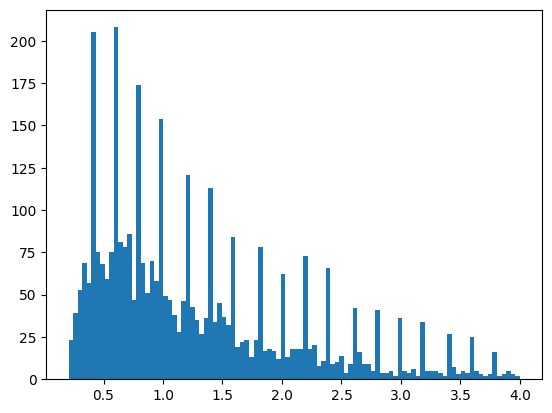

In [71]:
# histogram of lengths
plt.hist(snippet_df['length'], bins = 100)

In [72]:
snippet_df.shape

(3587, 4)

In [73]:
snippet_df.label.value_counts()

growl    983
whine    972
pant     858
bark     774
Name: label, dtype: int64

## Augmenting data

In [74]:
augmented_df = snippet_df.copy()

In [75]:
max(augmented_df.label.value_counts())

983

In [76]:
augmentation_pipeline = AA.Compose([
    AA.AddGaussianNoise(p=0.2, min_amplitude=0.001, max_amplitude=0.015),
    AA.TimeStretch(p = 0.2, min_rate=0.8, max_rate=1.2,),
    AA.PitchShift(p=0.3, min_semitones=-4, max_semitones=4),
    AA.Shift(p=0.3, min_fraction=-0.5, max_fraction=0.5)
])

default_augment = AA.AddGaussianNoise(p=1.0, min_amplitude=0.001, max_amplitude=0.015)

In [77]:
# PICK THE DESIRED TARGET NUMBER OF SAMPLES PER CLASS
#target_n = 4000                                    # 3000 samples per class
target_n = max(augmented_df.label.value_counts())  # adjusts all to the largest class


for label in augmented_df.label.unique():
    # create df from current label
    df_label = augmented_df[augmented_df['label'] == label].reset_index(drop=True)
    current_n = len(df_label)
    missing_n = target_n - current_n
    if missing_n > 0:
        for i in range(missing_n):
            # choose random row from df_label
            random_row = random.randint(0, current_n-1)
            # create augmented audio
            augmented_audio = augmentation_pipeline(df_label['audio'][random_row], sample_rate=22050)
            # check if any augmentations were applied
            if augmented_audio is None:
                # apply default augmentation
                augmented_audio = default_augment(df_label['audio'][random_row], sample_rate=22050)
            # create new row with augmented audio
            new_row = df_label.iloc[random_row].copy()
            new_row['audio'] = augmented_audio
            new_row['file_name'] = 'aug_' + new_row['file_name']
            # append new row to df
            augmented_df = augmented_df.append(new_row, ignore_index=True)


/var/folders/x2/6gs4vmmn5bxgqplmvj03kx240000gn/T/ipykernel_74315/2945261176.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)


In [78]:
augmented_df.label.value_counts()

bark     983
growl    983
pant     983
whine    983
Name: label, dtype: int64

## Feature extraction


<span style="color:red;font-weight:bold">Use it only if you REALLY want to extract many audio features!!!! This takes loooooooong. </span>

In [79]:
def extract_features(row):
    y, sr = row['audio'], 22050
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    tonal_centroid = librosa.feature.tonnetz(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_flatness = librosa.feature.spectral_flatness(y=y)
    roll_off_frequency = librosa.feature.spectral_rolloff(y=y, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    chroma_vqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    rms_energy = librosa.feature.rms(y=y)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
    
    return mfcc, spectral_centroid, tonal_centroid, spectral_bandwidth, spectral_contrast, spectral_flatness, roll_off_frequency, chroma_stft, chroma_cqt, chroma_cens, chroma_vqt, mel_spectrogram, rms_energy, tonnetz, zero_crossing_rate

# Apply the function to each row in the dataframe
features = augmented_df.apply(extract_features, axis=1)
         
# Add the features to the dataframe as new columns
augmented_df['mfcc'] = features.apply(lambda x: x[0])                   
augmented_df['spectral_centroid'] = features.apply(lambda x: x[1])
augmented_df['tonal_centroid'] = features.apply(lambda x: x[2])
augmented_df['spectral_bandwidth'] = features.apply(lambda x: x[3])
augmented_df['spectral_contrast'] = features.apply(lambda x: x[4])
augmented_df['spectral_flatness'] = features.apply(lambda x: x[5])
augmented_df['roll_off_frequency'] = features.apply(lambda x: x[6])
augmented_df['chroma_stft'] = features.apply(lambda x: x[7])
augmented_df['chroma_cqt'] = features.apply(lambda x: x[8])
augmented_df['chroma_cens'] = features.apply(lambda x: x[9])
augmented_df['chroma_vqt'] = features.apply(lambda x: x[10])
augmented_df['mel_spectrogram'] = features.apply(lambda x: x[11])
augmented_df['rms_energy'] = features.apply(lambda x: x[12])
augmented_df['tonnetz'] = features.apply(lambda x: x[13])
augmented_df['zero_crossing_rate'] = features.apply(lambda x: x[14])

/Users/rblc/.pyenv/versions/3.10.6/envs/laica/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/rblc/.pyenv/versions/3.10.6/envs/laica/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=480
  return f(*args, **kwargs)
/Users/rblc/.pyenv/versions/3.10.6/envs/laica/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=240
  return f(*args, **kwargs)
/Users/rblc/.pyenv/versions/3.10.6/envs/laica/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=750
  return f(*args, **kwargs)
/Users/rblc/.pyenv/versions/3.10.6/envs/laica/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=375
  return f(*args, 

In [80]:
augmented_df.columns

Index(['file_name', 'length', 'audio', 'label', 'mfcc', 'spectral_centroid',
       'tonal_centroid', 'spectral_bandwidth', 'spectral_contrast',
       'spectral_flatness', 'roll_off_frequency', 'chroma_stft', 'chroma_cqt',
       'chroma_cens', 'chroma_vqt', 'mel_spectrogram', 'rms_energy', 'tonnetz',
       'zero_crossing_rate'],
      dtype='object')

In [81]:
'''# Saving all features to a pickle file

with open('all_features_raw.pkl', "wb") as file:
    pickle.dump(augmented_df, file)'''

'# Saving all features to a pickle file\n\nwith open(\'all_features_raw.pkl\', "wb") as file:\n    pickle.dump(augmented_df, file)'

## Feature engineering

In [82]:
engineered_df = augmented_df.copy()
engineered_df = engineered_df.drop(['audio', 'file_name', 'length'], axis=1)

In [83]:
engineered_df.head()

,label,mfcc,spectral_centroid,tonal_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,roll_off_frequency,chroma_stft,chroma_cqt,chroma_cens,chroma_vqt,mel_spectrogram,rms_energy,tonnetz,zero_crossing_rate
0,bark,"[[-250.46988, -118.261406, -44.761337, -15.150...","[[2046.2046259400604, 2099.150545524592, 2139....","[[-0.05564062640428977, -0.054857160710814444,...","[[2272.7644749065025, 2248.785409692656, 2173....","[[10.083532507545424, 15.717628307983748, 9.81...","[[0.015135139, 0.01321015, 0.012281442, 0.0118...","[[3531.4453125, 3585.2783203125, 3402.24609375...","[[1.0, 0.6266294, 0.47994635, 0.2713824, 0.375...","[[1.0, 0.761777, 0.5393927, 0.54491305, 0.8998...","[[0.40428674, 0.39814296, 0.39209375, 0.386269...","[[1.0, 0.761777, 0.5393927, 0.54491305, 0.8998...","[[0.012915908, 0.031311706, 0.028881935, 0.103...","[[0.07139338, 0.1563148, 0.23387022, 0.2687045...","[[-0.05564062640428977, -0.054857160710814444,...","[[0.0478515625, 0.0732421875, 0.10205078125, 0..."
1,bark,"[[-176.08405, -18.083525, 42.982418, 33.61822,...","[[1609.62591927836, 1948.7073203481798, 2014.9...","[[-0.015406250679337048, -0.009881380995626738...","[[1535.0250645735653, 1846.5339566538146, 1910...","[[9.644357603893091, 7.285190595755207, 11.147...","[[0.004922074, 0.011850157, 0.014192977, 0.013...","[[2110.25390625, 3057.71484375, 3413.012695312...","[[0.19353837, 0.11841499, 0.11573104, 0.120078...","[[0.7320076, 0.49557084, 0.32487896, 0.2811330...","[[0.24546996, 0.24526928, 0.24507686, 0.244902...","[[0.7320076, 0.49557084, 0.32487896, 0.2811330...","[[0.005619203, 1.3658165, 6.378502, 4.3579183,...","[[0.19002177, 0.30884305, 0.38978156, 0.473680...","[[-0.015406250679337048, -0.009881380995626738...","[[0.05419921875, 0.080078125, 0.11279296875, 0..."
2,bark,"[[-175.92497, -88.45043, -67.50282, -94.0971, ...","[[1930.8328560150317, 1517.778187998585, 1375....","[[-0.0012710455864757947, -0.01302604855656250...","[[2313.0619044188634, 1738.5310795404746, 1456...","[[3.7725268295280836, 10.499280953845263, 15.7...","[[0.011582054, 0.0036919557, 0.0015853869, 0.0...","[[3057.71484375, 1798.0224609375, 1636.5234375...","[[0.54150945, 0.6418685, 0.18012051, 0.0116149...","[[0.65170974, 0.7272599, 0.41691503, 0.0877563...","[[0.33736077, 0.3405369, 0.3433404, 0.34583485...","[[0.65170974, 0.7272599, 0.41691503, 0.0877563...","[[0.0055523715, 0.0052145724, 0.0043094, 0.003...","[[0.14216626, 0.23925859, 0.29877156, 0.331212...","[[-0.0012710455864757947, -0.01302604855656250...","[[0.08642578125, 0.107421875, 0.1357421875, 0...."
3,bark,"[[-245.23177, -121.85542, -50.511383, -11.7700...","[[1566.8024789391602, 1853.0742714616822, 2026...","[[0.00782624757465723, 0.021310105574102033, -...","[[1963.8341808660134, 2081.2050402689824, 2070...","[[2.480265752183108, 6.236284359005937, 8.7809...","[[0.0062686424, 0.0078483755, 0.0074383565, 0....","[[2325.5859375, 2616.2841796875, 2777.78320312...","[[0.17328402, 0.23433262, 0.06043713, 0.043677...","[[0.45982212, 0.9552435, 0.31391752, 0.1673217...","[[0.2533056, 0.2546579, 0.25591376, 0.2570644,...","[[0.45982212, 0.9552435, 0.31391752, 0.1673217...","[[0.032042585, 0.05917298, 0.08950201, 0.30155...","[[0.06986247, 0.19150606, 0.27558914, 0.347435...","[[0.00782624757465723, 0.021310105574102033, -...","[[0.03857421875, 0.06787109375, 0.1015625, 0.1..."
4,bark,"[[-266.85577, -239.71031, -244.70642, -225.133...","[[1103.5045337632087, 1047.9993425005891, 1150...","[[0.00614843066997259, 0.014913669599556506, 0...","[[1698.4888190744655, 1602.7503820915176, 1707...","[[16.79821290552256, 25.531855865787225, 25.43...","[[0.003746834, 0.002376483, 0.0021103697, 0.00...","[[1614.990234375, 1496.5576171875, 1733.422851...","[[0.69910526, 0.65852654, 0.869821, 0.47733954...","[[0.4026729, 0.43573642, 0.5265607, 0.3554853,...","[[0.18631214, 0.18859926, 0.19088387, 0.193143...","[[0.4026729, 0.43573642, 0.5265607, 0.3554853,...","[[1.1206589, 1.7128664, 0.9509129, 1.9302347, ...","[

In [84]:
def calculate_nested_stats(df, col_name):

    # Calculate median of first nested array only
    nested_median_func = lambda x: np.median(x[0])
    median_values = np.array(df[col_name].apply(nested_median_func).tolist())
    median_col_name = f"{col_name}_median"
    df[median_col_name] = pd.DataFrame(median_values)
    
    return df

for column_name in engineered_df.columns:
    if isinstance(engineered_df[column_name][0], np.ndarray):
        engineered_df = calculate_nested_stats(engineered_df, column_name)
        engineered_df = engineered_df.drop(columns = column_name)
        
engineered_df.head(2)


,label,mfcc_median,spectral_centroid_median,tonal_centroid_median,spectral_bandwidth_median,spectral_contrast_median,spectral_flatness_median,roll_off_frequency_median,chroma_stft_median,chroma_cqt_median,chroma_cens_median,chroma_vqt_median,mel_spectrogram_median,rms_energy_median,tonnetz_median,zero_crossing_rate_median
0,bark,-102.055176,1666.317100,-0.024824,1938.749922,11.108585,0.006765,2470.935059,0.374490,0.565050,0.343813,0.565050,0.147281,0.208743,-0.024824,0.082520
1,bark,-117.979202,1553.578163,-0.004136,1570.977659,10.175662,0.004028,2088.720703,0.362602,0.579991,0.310145,0.579991,0.043794,0.216104,-0.004136,0.085938


In [85]:
'''

THIS CODE CALCULATES THE MEDIAN OF EACH NESTED ARRAY INSTEAD OF JUST THE FIRST ONE
DON'T DELETE THIS YET. IT MIGHT BE USEFUL LATER


def calculate_nested_stats(df, col_name):

    # Calculate median values
    nested_median_func = lambda x: np.median(np.array(x), axis=1)
    median_values = np.array(df[col_name].apply(nested_median_func).tolist())
    num_cols = median_values.shape[1]
    median_col_names = [f"{col_name}_median_{i+1}" for i in range(num_cols)]
    df[median_col_names] = pd.DataFrame(median_values)
    
    return df

for column_name in engineered_df.columns:
    if isinstance(engineered_df[column_name][0], np.ndarray):
        engineered_df = calculate_nested_stats(engineered_df, column_name)
        engineered_df = engineered_df.drop(columns = column_name)
        
engineered_df.head(2)'''
pass

In [86]:
engineered_df.head()

,label,mfcc_median,spectral_centroid_median,tonal_centroid_median,spectral_bandwidth_median,spectral_contrast_median,spectral_flatness_median,roll_off_frequency_median,chroma_stft_median,chroma_cqt_median,chroma_cens_median,chroma_vqt_median,mel_spectrogram_median,rms_energy_median,tonnetz_median,zero_crossing_rate_median
0,bark,-102.055176,1666.317100,-0.024824,1938.749922,11.108585,0.006765,2470.935059,0.374490,0.565050,0.343813,0.565050,0.147281,0.208743,-0.024824,0.082520
1,bark,-117.979202,1553.578163,-0.004136,1570.977659,10.175662,0.004028,2088.720703,0.362602,0.579991,0.310145,0.579991,0.043794,0.216104,-0.004136,0.085938
2,bark,-124.172203,1370.298405,0.001403,1614.113058,10.939909,0.001585,1625.756836,0.443589,0.629050,0.376062,0.629050,0.008314,0.209051,0.001403,0.086426
3,bark,-94.421028,1634.525174,-0.034998,1755.269003,8.735654,0.004762,2207.153320,0.164390,0.541706,0.273086,0.541706,0.073518,0.207951,-0.034998,0.086670
4,bark,-255.781097,1152.405352,0.024343,1740.842093,22.098719,0.001730,1986.437988,0.691929,0.535541,0.207017,0.535541,1.929686,0.029920,0.024343,0.036377


In [87]:
'''# Write engineered dataframe to pickle
with open('all_features_engineered.pkl', "wb") as file:
    pickle.dump(engineered_df, file)'''

'# Write engineered dataframe to pickle\nwith open(\'all_features_engineered.pkl\', "wb") as file:\n    pickle.dump(engineered_df, file)'

## Preparation for the model

In [88]:
df = engineered_df.copy()

In [89]:
from sklearn.preprocessing import LabelEncoder

test_ratio = 0.2  # the percentage of data to be allocated to test set

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])  # add a new column for encoded labels

groups = df.groupby('label_encoded')

train_indices = []
test_indices = []

# loop over each group and split it into train and test
for _, group in groups:
    n = len(group)
    n_test = int(np.ceil(n * test_ratio))  # number of samples to be allocated to test set
    n_train = n - n_test  # number of samples to be allocated to train set
    indices = group.index.to_list()
    # shuffle indices to randomly select the samples for test and train sets
    np.random.shuffle(indices)
    test_indices += indices[:n_test]
    train_indices += indices[n_test:]

# create train and test dataframes
train_df = df.loc[train_indices]
test_df = df.loc[test_indices]


In [90]:
# Set X and y
X_train = train_df.drop(['label', 'label_encoded'], axis=1)
y_train = train_df['label_encoded']
X_test = test_df.drop(['label', 'label_encoded'], axis=1)
y_test = test_df['label_encoded']

In [91]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [92]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

## Saving the model

In [98]:
'''# Save the scaler to disk
filename = '/Users/rblc/code/iamrblc/laica/scaler.pkl'
pickle.dump(scaler, open(filename, 'wb'))

# Save the model to disk
filename = '/Users/rblc/code/iamrblc/laica/xgboost_model.pkl'
pickle.dump(model, open(filename, 'wb'))'''
pass

## Testing the model

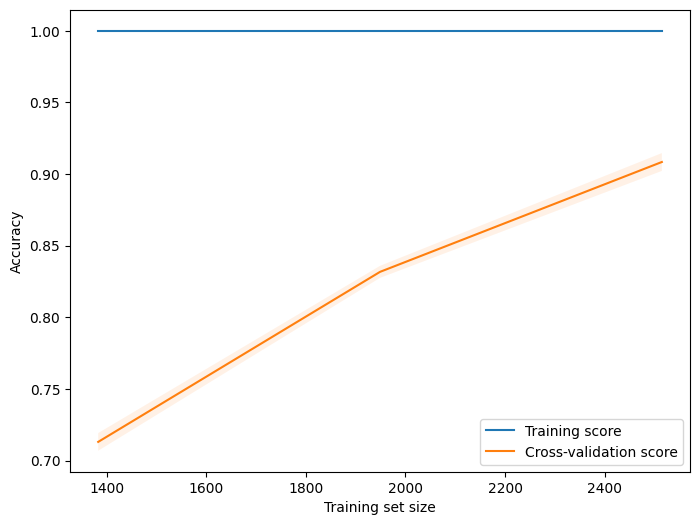

In [95]:
# Generate the learning curves using the trained model
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5)

# Plot the learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1), np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1)
plt.fill_between(train_sizes, np.mean(val_scores, axis=1) - np.std(val_scores, axis=1), np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), alpha=0.1)
plt.legend()
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Check label encoding
encoded_classes = dict(zip(le.classes_, le.transform(le.classes_)))
encoded_classes

{'bark': 0, 'growl': 1, 'pant': 2, 'whine': 3}

In [ ]:
y_proba = model.predict_proba(X_test)

# Define the encoded classes dictionary
encoded_classes = dict(zip(le.classes_, le.transform(le.classes_)))

# Invert the encoded classes dictionary to get a mapping of class indices to their labels
class_labels = {v: k for k, v in encoded_classes.items()}

# Print the predicted probabilities for each class with their corresponding labels and the actual label
for i, (proba, actual_label) in enumerate(zip(y_proba, y_test)):
    actual_label = le.inverse_transform([actual_label])[0]
    print(f"Sample {i+1} is a {actual_label}. The predicted probabilities:")
    for j, p in enumerate(proba):
        class_label = class_labels[j]
        print(f"{class_label}: {p*100:.4f}")

Sample 1 is a bark. The predicted probabilities:
bark: 99.7641
growl: 0.0005
pant: 0.0353
whine: 0.2000
Sample 2 is a bark. The predicted probabilities:
bark: 98.3806
growl: 0.1822
pant: 0.1810
whine: 1.2562
Sample 3 is a bark. The predicted probabilities:
bark: 99.9723
growl: 0.0002
pant: 0.0006
whine: 0.0269
Sample 4 is a bark. The predicted probabilities:
bark: 91.4592
growl: 0.0473
pant: 0.1975
whine: 8.2960
Sample 5 is a bark. The predicted probabilities:
bark: 99.9979
growl: 0.0001
pant: 0.0000
whine: 0.0020
Sample 6 is a bark. The predicted probabilities:
bark: 99.9598
growl: 0.0213
pant: 0.0098
whine: 0.0090
Sample 7 is a bark. The predicted probabilities:
bark: 2.2220
growl: 0.5342
pant: 55.4197
whine: 41.8241
Sample 8 is a bark. The predicted probabilities:
bark: 99.9628
growl: 0.0352
pant: 0.0009
whine: 0.0010
Sample 9 is a bark. The predicted probabilities:
bark: 99.9849
growl: 0.0000
pant: 0.0001
whine: 0.0149
Sample 10 is a bark. The predicted probabilities:
bark: 99.5274

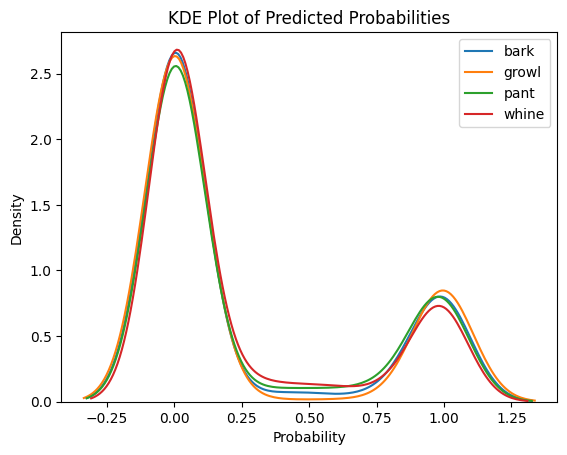

In [ ]:
# Create a list of class labels for the legend
legend_labels = [class_labels[i] for i in range(len(class_labels))]

# Create a KDE plot for each class
for i in range(len(class_labels)):
    class_proba = y_proba[:, i]
    sns.kdeplot(class_proba, label=legend_labels[i])

# Set the plot title and axis labels
plt.title("KDE Plot of Predicted Probabilities")
plt.xlabel("Probability")
plt.ylabel("Density")

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()